In [1]:
from IPython.display import Audio, display
import numpy as np

# What is GWpy?

### The GWpy package contains classes and utilities providing tools and methods for studying data from gravitational-wave detectors, for astrophysical or instrumental purposes.

# The basic idea

### The basic idea of GWpy is to simplify all of the tedious bits of analysing data, allowing users to study and plot data quickly and effectively. For example, GWpy provides simple methods for input/output:

In [2]:
from gwpy.timeseries import TimeSeries
h1 = TimeSeries.fetch_open_data('H1', 1126259457, 1126259467)
l1 = TimeSeries.fetch_open_data('L1', 1126259457, 1126259467)

### and signal processing:

In [3]:
h1b = h1.bandpass(50, 250).notch(60).notch(120)
l1b = l1.bandpass(50, 250).notch(60).notch(120)
l1b.shift('6.9e-3s')
l1b *= -1

/home/felipe/anaconda3/envs/cosmo_env/lib/python3.7/site-packages/gwpy/plot/plot.py:281: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super(Plot, self).show(warn=warn)


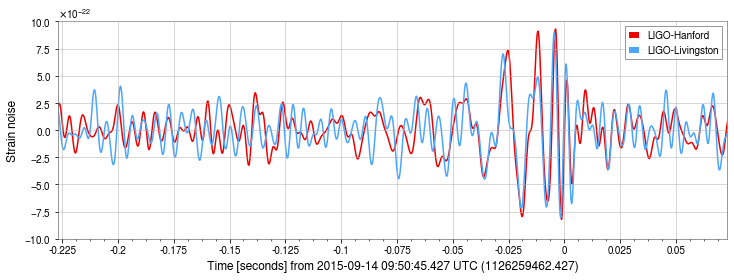

In [4]:
from gwpy.plot import Plot
plot = Plot(figsize=(12, 4))
ax = plot.gca(xscale='auto-gps')
ax.plot(h1b, color='gwpy:ligo-hanford', label='LIGO-Hanford')
ax.plot(l1b, color='gwpy:ligo-livingston', label='LIGO-Livingston')
ax.set_epoch(1126259462.427)
ax.set_xlim(1126259462.2, 1126259462.5)
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain noise')
ax.legend()
plot.show()

# What is PyCBC?

### PyCBC is a software package used to explore astrophysical sources of gravitational waves. It contains algorithms that can detect coalescing compact binaries and measure the astrophysical parameters of detected sources. PyCBC was used in the first direct detection of gravitational waves by LIGO and is used in the ongoing analysis of LIGO and Virgo data. PyCBC was featured in Physics World as a good example of a large collaboration publishing its research products, including its software.

### Since we are on a speedrun tutorial and we are only interested on generate pseudo-data to training our deep learning models,we are not going to explore with full detail these packages, however if you are feeling adventures, I recommend to go through their tutorial sessions:

PyCBC:
- https://github.com/gwastro/PyCBC-Tutorials/tree/master/examples

GWpy:
- https://gwpy.github.io/docs/stable/

### They have very good examples and you can run on the google collab.

<img src="./figs/link.jpg" style="width: 750px;" align="center"/>

### can we build a deep learning model capable of distinguish between random noise and a possible GW signal?

### First we need data. Luckily since the first observation in 2016 LIGO is collecting more and more events. However, we need a lot of data to properly train our models. Unfortunately we still don't have access to a technology capable of producing black holes in a controllable environment to produce and collect more data 😔

### Fortunately we have computers and quite smart people (a.k.a. grad students and post-docs) willing to convert general relativity equation in simulations. We can leverage these simulations for our own purpose. 

## The type of data:

### The next step is to decide what type of data we want to work:

<table><tr>
    <td><img src="./figs/GW170818_R1.png" style="width: 550px;"/></td> 
    <td><img src='./figs/Composite_image.png' style="width: 550px;"></td>
</tr></table>

### Time-series data:

In [5]:
ts = np.load('../super resolution GW/data time series/poluted/367_29.3_29.7_1294_4.5100_1.8455_-0.1675_2.2711.npy')
ts

array([[-0.00499978,  0.00984042,  0.02339693, ...,
         0.02734583,  0.01885281,  0.00897741],
       [-0.0117982 ,  0.00871707,  0.0282642 , ...,
         0.0020279 ,  0.00333662,  0.00502525],
       [ 0.03545141,  0.07993586,  0.11895382, ...,
         0.00623361,  0.01291366,  0.0176291 ]])

### Or even sound:

In [8]:
ad = Audio('../super resolution GW/data WAV/pure/68_13.2_14.1_752_0.6152_3.8104_-0.5222_2.3850.wav',rate=4096)

In [9]:
ad

# For simplicity we are going to work with the image data.

### objectives:
- Create a set of images from the simulated waveforms generated from different parameters (chirp mass, distance from source, ...) for BBH merges and use Q-transform  to generate images.
- Create a classification CNN model to distinguish between possible events and just random noise.

### lets import the packages we need:

In [10]:
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
from pycbc.filter import matched_filter
from gwpy.timeseries import TimeSeries
from PIL import Image
from multiprocessing import Pool, cpu_count
from glob import glob
import random
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### One important aspect of our data is the noise

In [11]:
!ls ../super\ resolution\ GW/noise\ data

longer_noise.hdf5     noise_shift_1000_H1.hdf5	noise_shift_2000_L1.hdf5
longer_noise_L1.hdf5  noise_shift_1000_L1.hdf5	noise_shift_2000_V1.hdf5
longer_noise_V1.hdf5  noise_shift_1000_V1.hdf5	noises.zip
long_noise.hdf5       noise_shift_2000_H1.hdf5


In [12]:
#Import noise timeseries. 
noiseh1_1=TimeSeries.read('../super resolution GW/noise data/longer_noise.hdf5')
noisel1_1=TimeSeries.read('../super resolution GW/noise data/longer_noise_L1.hdf5')
noisev1_1=TimeSeries.read('../super resolution GW/noise data/longer_noise_V1.hdf5')

noiseh1_2=TimeSeries.read('../super resolution GW/noise data/noise_shift_1000_H1.hdf5')
noisel1_2=TimeSeries.read('../super resolution GW/noise data/noise_shift_1000_L1.hdf5')
noisev1_2=TimeSeries.read('../super resolution GW/noise data/noise_shift_1000_V1.hdf5')

noiseh1_3=TimeSeries.read('../super resolution GW/noise data/noise_shift_2000_H1.hdf5')
noisel1_3=TimeSeries.read('../super resolution GW/noise data/noise_shift_2000_L1.hdf5')
noisev1_3=TimeSeries.read('../super resolution GW/noise data/noise_shift_2000_V1.hdf5')

### note that we have 9 noise time series, where we have 2 different sample rates and 3 detectors (Ligo L1, H1 and Virgo).

In [13]:
noiseh1_1.sample_rate,noiseh1_2.sample_rate,noiseh1_3.sample_rate

(<Quantity 16384. Hz>, <Quantity 4096. Hz>, <Quantity 4096. Hz>)

In [14]:
#Define directory where images will be saved
path = './data for classification/'

In [15]:
#create folders if they don't exist
if(not os.path.isdir(f'{path}')):
    os.mkdir(f'{path}')

In [16]:
#create folders for sig and bg classes:
if(not os.path.isdir(f'{path}/sig')):
    os.mkdir(f'{path}/sig')
if(not os.path.isdir(f'{path}/bg')):
    os.mkdir(f'{path}/bg')

### One of the main part of our code is the waveform we want to simulate, PyCBC comes with a very good function called get_td_waveform, the td stands for time domain:

In [17]:
get_td_waveform?

Signature: get_td_waveform(template=None, **kwargs)
Docstring:
Return the plus and cross polarizations of a time domain waveform.

Parameters
----------
template: object
    An object that has attached properties. This can be used to subsitute
    for keyword arguments. A common example would be a row in an xml table.
mass1 : {None, <class 'float}
    The mass of the first component object in the binary (in solar masses).
mass2 : {None, <class 'float}
    The mass of the second component object in the binary (in solar masses).
spin1x : {0.0, <class 'float}
    The x component of the first binary component's dimensionless spin.
spin1y : {0.0, <class 'float}
    The y component of the first binary component's dimensionless spin.
spin1z : {0.0, <class 'float}
    The z component of the first binary component's dimensionless spin.
spin2x : {0.0, <class 'float}
    The x component of the second binary component's dimensionless spin.
spin2y : {0.0, <class 'float}
    The y component of the s

### where we provide some input parameters and the return of this function are the time series for the + and x polarizations waveforms.

In [36]:
hp, hc = get_td_waveform(approximant='SEOBNRv4_opt', mass1=20, mass2=25,
                                f_lower=20, f_final=noiseh1_1.sample_rate.value, distance=600,
                                inclination=np.radians(90), delta_t=noiseh1_1.dt.value)

### lets check hp and hc:

In [37]:
hp.shape

(25264,)

In [38]:
noiseh1_1.shape

(131072,)

In [39]:
hpb = TimeSeries.from_pycbc(hp)
hpb = hpb.bandpass(50, 250).notch(60).notch(120)

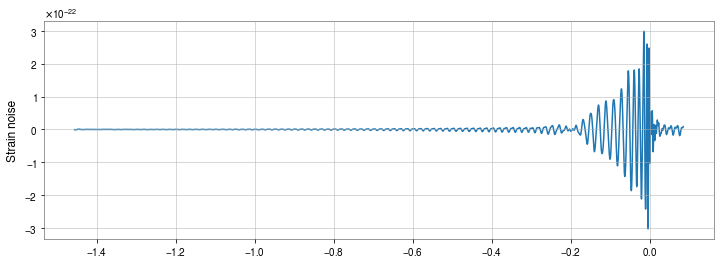

In [40]:
plot = Plot(figsize=(12, 4))
ax = plot.gca()
ax.plot(hpb)
ax.set_ylabel('Strain noise')
plot.show()

# Generate the Q-transform of a TimeSeries:

### One of the most useful tools for filtering and visualising short-duration features in a TimeSeries is the Q-transform. This is regularly used by the Detector Characterization working groups of the LIGO Scientific Collaboration and the Virgo Collaboration to produce high-resolution time-frequency maps of transient noise (glitches) and potential gravitational-wave signals.

In [23]:
hpb.q_transform?

Signature:
hpb.q_transform(
    qrange=(4, 64),
    frange=(0, inf),
    gps=None,
    search=0.5,
    tres='<default>',
    fres='<default>',
    logf=False,
    norm='median',
    mismatch=0.2,
    outseg=None,
    whiten=True,
    fduration=2,
    highpass=None,
    **asd_kw,
)
Docstring:
Scan a `TimeSeries` using the multi-Q transform and return an
interpolated high-resolution spectrogram

By default, this method returns a high-resolution spectrogram in
both time and frequency, which can result in a large memory
footprint. If you know that you only need a subset of the output
for, say, a figure, consider using ``outseg`` and the other
keyword arguments to restrict the size of the returned data.

Parameters
----------
qrange : `tuple` of `float`, optional
    `(low, high)` range of Qs to scan

frange : `tuple` of `float`, optional
    `(log, high)` range of frequencies to scan

gps : `float`, optional
    central time of interest for determine loudest Q-plane

search : `float`, opti

### We want our waveform be close as possible to a real GW event. Since the detectors have an inherent random noise, its a good idea to invect this noise into our waveform. Frist we need to align our waveform start to a randon segment we choose from the noise:

In [41]:
#Line up model and background
offset = random.randint(len(hp),len(noiseh1_1)-len(hp))
t0 = noiseh1_1.times[offset].value
hp.start_time = hc.start_time = t0

### after this we can convert the waveform generated from pycbc to a timeseries which GWpy can handle:

In [42]:
hpb = TimeSeries.from_pycbc(hp)
hpb = hpb.bandpass(50, 250).notch(60).notch(120) #comment about the filters!!!

### Next we focus our attention to the region where the waveform reach it peak, this will help us to save some memory when we will produce the Q-graphs:

In [43]:
tm_idx = hpb.argmax()
tm = hpb.times.value[tm_idx]
tm = tm-random.random()*0.02+0.01

### We can check what we did:

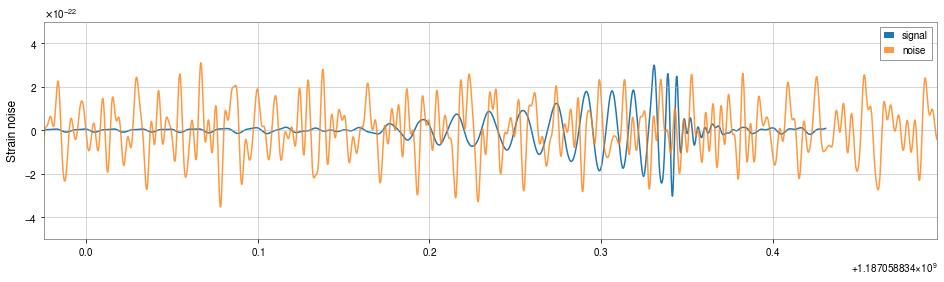

In [44]:
plot = Plot(figsize=(16, 4))
ax = plot.gca()
ax.plot(hpb, label='signal')
ax.plot(noiseh1_1.bandpass(50, 250).notch(60).notch(120),alpha=0.8,label='noise')
ax.set_ylabel('Strain noise')
ax.set_ylim(-0.5e-21, 0.5e-21)
ax.set_xlim(tm-0.36,tm+0.16)
ax.legend()
plot.show()

### We also need to crop the random noise around the peak of our waveform:

In [45]:
noiseh1_1 = noiseh1_1.crop(tm-4,tm+4)

### Another key element for our Q-graph is the ASD, the Amplitude Spectral Density (ASD) is a key indicator of frequency-domain sensitivity for a gravitational-wave detector.

In [46]:
#Calculate asd
fft_lenght1 = int(max(2, np.ceil(2048 * noiseh1_1.dt.decompose().value)))
asd_h1 = noiseh1_1.asd(overlap=0, fftlength=fft_lenght1, window='hanning', method='welch')
asd_h1 = asd_h1.interpolate(1./noiseh1_1.duration.decompose().value)

### Don't forget to inject the noise into our signal!!!

In [47]:
#Inject model into the background
sig_h1 = noiseh1_1.inject(hpb)

### Applying some basic filters: 

In [48]:
tres=(abs(-tm+.16+tm+.04)/275)
fres= 280/275
#Apply whitening, frequency filters
sig_h1 = sig_h1.whiten(asd=asd_h1).bandpass(20,300).notch(60).notch(120).notch(240)

In [49]:
#Calculate Q-transform
sig_qt_h1 = sig_h1.q_transform(outseg=(tm-.16,tm+.04), tres=tres, norm='median', frange=(20,300), fres = fres)

### Low and behold, we finaly have our Imgae:

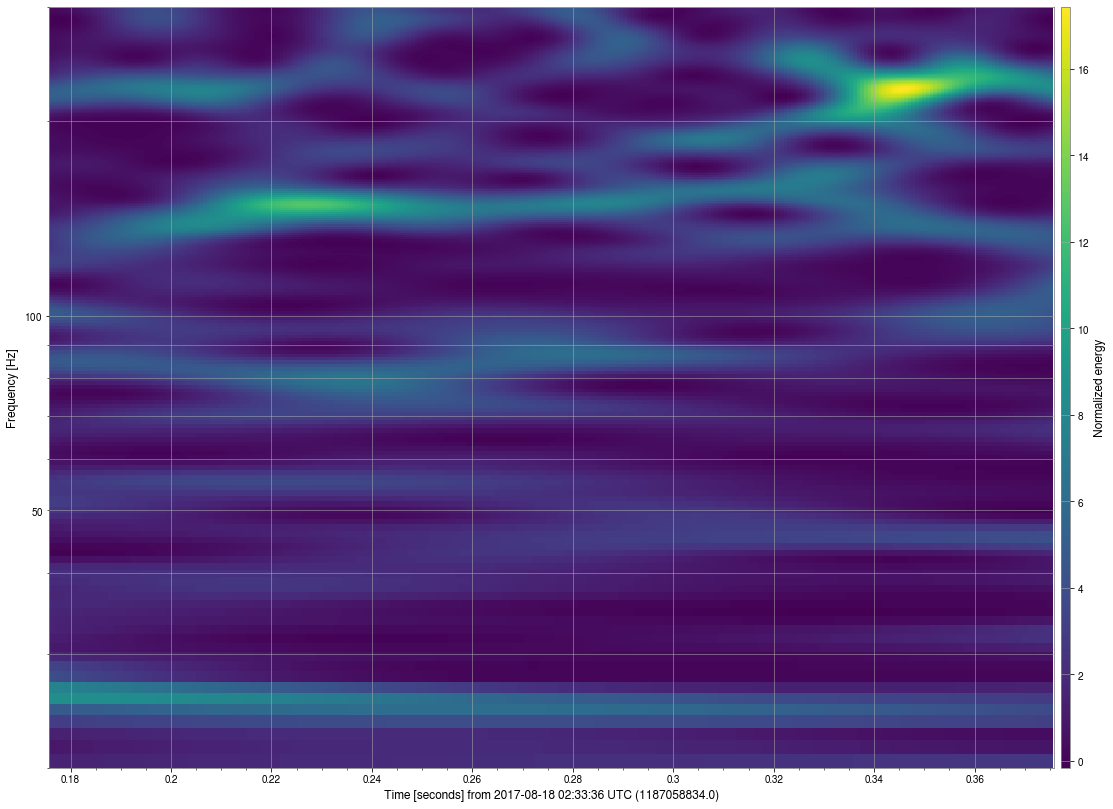

In [50]:
plot = sig_qt_h1.plot(figsize=[18, 14])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 300)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

### summarizing:

- randomly select the pair of mass for the BH
- set a distance range from earth to the pair, and from this range we draw random distances.
- randomly select values for incliniation of the binary system.
- randomly select the parameters for right ascension, declination and polarization (important for the detectors effects)
- generate the wave-form based on these criteria and only keep the plus-polarization (we are interested on the Q-graphs)
- randomly select a window on the noise and we will inject this noise into our waveform.
- apply whitning and other filters into our waveform.
- generate the q-graph.
- save the q-graph as an image using PIL.

### now we need to create a function which wraps all the steps we did above to generate our dataset.

In [51]:
det_h1=Detector('H1')
det_l1=Detector('L1')
det_v1=Detector('V1')

In [ ]:
#Define function to be able to use multithreading
def create_image(i):
    seed=random.random()*3
    if(seed<1):
        noiseh1=noiseh1_1
        noisel1=noisel1_1
        noisev1=noisev1_1
    elif(seed<2):
        noiseh1=noiseh1_2
        noisel1=noisel1_2
        noisev1=noisev1_2
    else:
        noiseh1=noiseh1_3
        noisel1=noisel1_3
        noisev1=noisev1_3
        
    
    right_ascension=random.random()*2*np.pi
    declination=random.random()*2*np.pi-np.pi
    polarization = random.random()*2*np.pi
    sample_rate=int(noiseh1.sample_rate.value)    
    dt=noiseh1.dt.value
    mmax = 50
    det_ref = random.choice([det_h1,det_l1,det_v1])
    try:
        #Set parameters and generate model waveform
        ma = np.round(4 + random.random()*(mmax-4) ,1)
        mb = np.round((ma + random.random()*(mmax-ma)),1) 
        
        dist = int(random.uniform(int(500 * (1 - 0.35)), int(500 * (1 + 0.35))))
        
        #incli= np.radians(random.uniform(0,90))
        incli = random.random()*2*np.pi 
        
        if (ma and mb)>4:
            approx='SEOBNRv4_opt' 
        else:
            approx='TaylorF2'
        
        bg_h1=noiseh1
        bg_l1=noisel1
        bg_v1=noisev1
        
        hp, hc = get_td_waveform(approximant=approx, mass1=ma, mass2=mb,
                                f_lower=20, f_final=sample_rate, distance=dist,
                                inclination=incli, delta_t=dt)
        
        
        ####FOR INJECTION IN A RANDOM SNIPPET OF NOISE############
        
        #Calculate offset 
        offset = random.randint(len(hp),len(bg_h1)-len(hp))
        #Line up model and background
        t0 = bg_h1.times[offset].value
        hp.start_time = hc.start_time = t0
        ######### times delays
        tdelays = {}
        for d in [det_h1,det_l1,det_v1]:
            dt = d.time_delay_from_detector(det_ref, right_ascension, declination, t0)
            tdelays[d.name] = dt
        
        ###########################################################
        #project waves into H1 detector:
        pw_H1 = det_h1.project_wave(hp, hc, right_ascension, declination, polarization)
        pw_L1 = det_l1.project_wave(hp, hc, right_ascension, declination, polarization)
        pw_V1 = det_v1.project_wave(hp, hc, right_ascension, declination, polarization)
        #Convert to GWPY format
        model_h1 = TimeSeries.from_pycbc(pw_H1)
        model_l1 = TimeSeries.from_pycbc(pw_L1)
        model_v1 = TimeSeries.from_pycbc(pw_V1)
        
        
        #Get the index (and respective time value) of the maximum of the model amplitude
        #This defines the region of the merger
        tm_idx = model_h1.argmax()
        tm = model_h1.times.value[tm_idx]
        tm = tm-random.random()*0.02+0.01
        bg_h1 = bg_h1.crop(tm-4,tm+4)
        bg_l1 = bg_l1.crop(tm-4,tm+4)
        bg_v1 = bg_v1.crop(tm-4,tm+4)
        
        
        #Calculate asd
        fft_lenght1 = int(max(2, np.ceil(2048 * bg_h1.dt.decompose().value)))
        asd_h1 = bg_h1.asd(overlap=0, fftlength=fft_lenght1, window='hanning', method='welch')
        asd_h1 = asd_h1.interpolate(1./noiseh1.duration.decompose().value) 
        
        fft_lenght2 = int(max(2, np.ceil(2048 * bg_l1.dt.decompose().value)))
        asd_l1 = bg_l1.asd(overlap=0, fftlength=fft_lenght2,window='hanning', method='welch')
        asd_l1 = asd_l1.interpolate(1./noisel1.duration.decompose().value)  
        
        fft_lenght3 = int(max(2, np.ceil(2048 * bg_v1.dt.decompose().value)))
        asd_v1 = bg_v1.asd(overlap=0, fftlength=fft_lenght3,window='hanning', method='welch')
        asd_v1 = asd_v1.interpolate(1./noisev1.duration.decompose().value)  
        
        #Inject model into the background
        sig_h1 = bg_h1.inject(model_h1)
        sig_l1 = bg_l1.inject(model_l1)
        sig_v1 = bg_v1.inject(model_v1)
        
        ##shifts:
        sig_l1.shift(f'{tdelays["L1"]}s')
        sig_h1.shift(f'{tdelays["H1"]}s')
        sig_v1.shift(f'{tdelays["V1"]}s')
        
        tres=(abs(-tm+.16+tm+.04)/275)
        fres= 280/275
        #Apply whitening, frequency filters and calculate Q-transforms
        sig_h1 = sig_h1.whiten(asd=asd_h1).bandpass(20,300).notch(60).notch(120).notch(240)
        sig_l1 = sig_l1.whiten(asd=asd_l1).bandpass(20,300).notch(60).notch(120).notch(240)
        sig_v1 = sig_v1.whiten(asd=asd_v1).bandpass(20,300).notch(60).notch(120).notch(240)

        bg_h1 = bg_h1.whiten(asd=asd_h1).bandpass(20,300).notch(60).notch(120).notch(240)
        bg_l1 = bg_l1.whiten(asd=asd_l1).bandpass(20,300).notch(60).notch(120).notch(240)
        bg_v1 = bg_v1.whiten(asd=asd_v1).bandpass(20,300).notch(60).notch(120).notch(240)
        
        #Calculate Q-transform matrices
        sig_qt_h1 = sig_h1.q_transform(outseg=(tm-.16,tm+.04), tres=tres, norm='median', frange=(20,300), fres = fres).value
        sig_qt_l1 = sig_l1.q_transform(outseg=(tm-.16,tm+.04), tres=tres, norm='median', frange=(20,300), fres = fres).value
        sig_qt_v1 = sig_v1.q_transform(outseg=(tm-.16,tm+.04), tres=tres, norm='median', frange=(20,300), fres = fres).value

        bg_qt_h1 = bg_h1.q_transform(outseg=(tm-.16,tm+.04), tres=tres, norm='median', frange=(20,300), fres = fres).value
        bg_qt_l1 = bg_l1.q_transform(outseg=(tm-.16,tm+.04), tres=tres, norm='median', frange=(20,300), fres = fres).value
        bg_qt_v1 = bg_v1.q_transform(outseg=(tm-.16,tm+.04), tres=tres, norm='median', frange=(20,300), fres = fres).value

        
        # Normalize as bw-images
        sig_qt_h1 = sig_qt_h1-sig_qt_h1.min()
        sig_qt_h1 = np.uint8(sig_qt_h1*255/sig_qt_h1.max())
        
        sig_qt_l1 = sig_qt_l1-sig_qt_l1.min()
        sig_qt_l1 = np.uint8(sig_qt_l1*255/sig_qt_l1.max())
        
        sig_qt_v1 = sig_qt_v1-sig_qt_v1.min()
        sig_qt_v1 = np.uint8(sig_qt_v1*255/sig_qt_v1.max())
        
        ### for BG
        bg_qt_h1 = bg_qt_h1-bg_qt_h1.min()
        bg_qt_h1 = np.uint8(bg_qt_h1*255/bg_qt_h1.max())
        
        bg_qt_l1 = bg_qt_l1-bg_qt_l1.min()
        bg_qt_l1 = np.uint8(bg_qt_l1*255/bg_qt_l1.max())
        
        bg_qt_v1 = bg_qt_v1-bg_qt_v1.min()
        bg_qt_v1 = np.uint8(bg_qt_v1*255/bg_qt_v1.max())
        
        
        
        #Create and save images (make sure the folders exist)
        sig_qt = np.stack([sig_qt_h1, sig_qt_l1, sig_qt_v1])
        sig_im=Image.fromarray(sig_qt.T)
        sig_im=sig_im.transpose(Image.FLIP_TOP_BOTTOM)
        sig_im = sig_im.resize((512,512))  
        sig_im.save(f'{path}/sig/{i}_{ma}_{mb}_{dist}_{incli:.4f}_{right_ascension:.4f}_{declination:.4f}_{polarization:.4f}.png')
        
        #BG
        bg_qt = np.stack([bg_qt_h1,bg_qt_l1,bg_qt_v1])
        bg_im=Image.fromarray(bg_qt.T)
        bg_im=bg_im.transpose(Image.FLIP_TOP_BOTTOM)
        bg_im = bg_im.resize((512,512)) 
        bg_im.save(f'{path}/bg/{i}.png')
        
    except:
        pass

<img src="./figs/IMG-20200918-WA0015.jpg" style="width: 650px;" align="center"/> 

In [ ]:
cpu_count()

In [ ]:
#Define number of threads to use
pool=Pool(8)
#Define number of images to create per class
num_images=5_000

In [ ]:
for i, _ in enumerate(pool.imap_unordered(create_image, range(num_images)), 1):
    sys.stderr.write('\rdone {0:2%}'.format(i/num_images))